In [5]:
%matplotlib inline

import os
import time
import copy
import pickle
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import h5py
from tqdm.auto import tqdm, trange
import umap
from sampler import ImbalancedDatasetSampler
from ood_metrics import auroc, plot_roc, plot_barcode, calc_metrics, detection_error, fpr_at_95_tpr
import mc_uncertainty as mc

import torch
from torch.nn import functional as F
from torchvision import transforms
import torchvision.models as models
from torchvision.datasets import CIFAR10, CIFAR100, ImageFolder, SVHN
from torch import nn, optim
import torch.utils.data
import torchvision

from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.svm import OneClassSVM
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve


CIFAR10_CLASSES = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
FG_CLASSES = list(map(CIFAR10_CLASSES.index, 
                 ["cat"]))
BG_CLASSES = list(map(CIFAR10_CLASSES.index, 
                 ["airplane", "automobile", "bird", "deer", "frog", "dog", "horse", "ship", "truck"]))

NUM_CLASSES = 2
INPUT_SIZE = 224
# INPUT_SIZE = 32
BATCH_SIZE = 64
NUM_FEATURE_LAYERS = 31

RESULTS_FILE = 'cifar10_2class.h5'

TRAIN = False

In [6]:
def create_model(kind='resnet152'):
    # Download pretrained model
    if kind == 'resnet152':
        model = models.resnet152(pretrained=True)
    elif kind == "densenet161":
        model = models.densenet161(pretrained=True)
    elif kind == "vgg16":
        model = models.vgg16(pretrained=True)
        
    # Freeze weights
    for param in model.parameters():
        param.requires_grad = False

    # Re-implement final classification layer
    if kind == 'resnet152':
        model.fc = nn.Linear(in_features=model.fc.in_features, out_features=NUM_CLASSES, bias=True)
    elif kind == "densenet161":
        model.classifier = nn.Linear(in_features=model.classifier.in_features, out_features=NUM_CLASSES, bias=True)
    elif kind == "vgg16":
        model.classifier[6] = nn.Linear(in_features=model.classifier[6].in_features, out_features=NUM_CLASSES, bias=True)

    return model


class ImbalancedDatasetSampler(torch.utils.data.sampler.Sampler):
    """Samples elements randomly from a given list of indices for imbalanced dataset
    Arguments:
        indices (list, optional): a list of indices
        num_samples (int, optional): number of samples to draw
    """

    def __init__(self, dataset, indices=None, num_samples=None):
                
        # if indices is not provided, 
        # all elements in the dataset will be considered
        self.indices = list(range(len(dataset))) \
            if indices is None else indices
            
        # if num_samples is not provided, 
        # draw `len(indices)` samples in each iteration
        self.num_samples = len(self.indices) \
            if num_samples is None else num_samples
            
        # distribution of classes in the dataset 
        label_to_count = {}
        for idx in self.indices:
            label = self._get_label(dataset, idx)
            if label in label_to_count:
                label_to_count[label] += 1
            else:
                label_to_count[label] = 1
                
        # weight for each sample
        weights = [1.0 / label_to_count[self._get_label(dataset, idx)]
                   for idx in self.indices]
        self.weights = torch.DoubleTensor(weights)

    def _get_label(self, dataset, idx):
        return dataset.target_transform(dataset.targets[idx])
                
    def __iter__(self):
        return (self.indices[i] for i in torch.multinomial(
            self.weights, self.num_samples, replacement=True))

    def __len__(self):
        return self.num_samples
        


def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, lr_scheduler=None):
    since = time.time()

    train_acc_history = []
    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in trange(num_epochs, desc="Epochs"):
        tqdm.write('Epoch {}/{}'.format(epoch, num_epochs - 1))
        tqdm.write('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in tqdm(dataloaders[phase], 
                                       total=len(dataloaders[phase]), 
                                       desc="{} batches".format(phase),
                                       leave=False):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            tqdm.write('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_loss = epoch_loss
                val_acc_history.append(epoch_acc)
            elif phase == 'train':
                train_acc_history.append(epoch_acc)
                
        if lr_scheduler is not None:
            lr_scheduler.step(val_loss)
            
        tqdm.write("\n")

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history


def save_model(model, path='model.pt'):
    torch.save(model.state_dict(), path)

    
def load_model(model, path):
    model.load_state_dict(torch.load(path))
    model.eval()


def plot_training_hist(train_hist, val_hist):
    thist = []
    vhist = []

    thist = [h.cpu().numpy() for h in train_hist]
    vhist = [h.cpu().numpy() for h in val_hist]

    plt.title("Accuracy vs. Number of Training Epochs")
    plt.xlabel("Training Epochs")
    plt.ylabel("Accuracy")
    plt.plot(range(1,NUM_EPOCHS+1),thist,label="Train")
    plt.plot(range(1,NUM_EPOCHS+1),vhist,label="Val")
    plt.legend()
    plt.show()
    
    
def save_history(train_hist, val_hist, train_hist_path='train_hist.pickle', val_hist_path='val_hist.pickle'):
    with open(train_hist_path, 'wb') as f:
        pickle.dump(train_hist, f)
    with open(val_hist_path, 'wb') as f:
        pickle.dump(val_hist, f)
        
        
def load_history(train_hist_path='train_hist.pickle', val_hist_path='val_hist.pickle'):
    with open(train_hist_path, 'rb') as f:
        train_hist = pickle.load(f)
    with open(val_hist_path, 'rb') as f:
        val_hist = pickle.load(f)
    return train_hist, val_hist


def evaluate_model(model, dataloader):
    running_corrects = 0
    
    for inputs, labels in tqdm(dataloader, total=len(dataloader)):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # forward
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            _, preds = torch.max(outputs, 1)

        # statistics
        running_corrects += torch.sum(preds == labels.data)

    accuracy = running_corrects.double() / len(dataloader.dataset)
    return accuracy.detach().cpu().item()

# Implement a pretrained classifer and finetuning for CIFAR 10

## Set up data loaders

Transform the training data as follows:
    - Remove all images with labels OOD_CLASSES
    - Change the labels:
        - 0: image is in FG_CLASSES (i.e it's a cat)
        - 1: image is one of BG_CLASSES (i.e. it's a airplane, automobile, bird, deer, dog, or frog)
        
Transform the test data as follows:
    - Change the labels:
        - 0: image is in FG_CLASSES (i.e it's a cat)
        - 1: image is one of BG_CLASSES (i.e. it's a airplane, automobile, bird, deer, dog, or frog)
        - 2: image is one of OOD_CLASSES (i.e. it's a horse, ship, or truck)

In [7]:
# Set up data loaders
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(INPUT_SIZE),
        transforms.RandomResizedCrop(INPUT_SIZE),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(INPUT_SIZE),
        transforms.CenterCrop(INPUT_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

def label_transform(y):
    if y in FG_CLASSES: return 0
    elif y in BG_CLASSES: return 1
    else: return 2

cifar10_train = CIFAR10('/media/tadenoud/DATADisk/datasets/cifar10/', train=True, transform=data_transforms['train'], 
                        target_transform=label_transform)
cifar10_train_no_aug = CIFAR10('/media/tadenoud/DATADisk/datasets/cifar10/', train=True, transform=data_transforms['val'],
                               target_transform=label_transform)
cifar10_test = CIFAR10('/media/tadenoud/DATADisk/datasets/cifar10/', train=False, transform=data_transforms['val'], 
                       target_transform=label_transform)
cifar100_ood = CIFAR100('/media/tadenoud/DATADisk/datasets/cifar100/', train=False, transform=data_transforms['val'],
                       target_transform=lambda y: y+NUM_CLASSES)
imagenet_resize = ImageFolder('/media/tadenoud/DATADisk/datasets/tiny-imagenet-200/test', transform=data_transforms['val'],
                             target_transform=lambda y: y+NUM_CLASSES)
svhn_ood = SVHN('/media/tadenoud/DATADisk/datasets/svhn', split='test', transform=data_transforms['val'],
                target_transform=lambda y: y+NUM_CLASSES)


dataloaders_dict = {
    'train': torch.utils.data.DataLoader(cifar10_train, batch_size=BATCH_SIZE, 
                                         sampler=ImbalancedDatasetSampler(cifar10_train),
                                         num_workers=4, pin_memory=True),
    'train_no_aug': torch.utils.data.DataLoader(cifar10_train_no_aug, batch_size=BATCH_SIZE, num_workers=4, pin_memory=True),
    'val': torch.utils.data.DataLoader(cifar10_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True),
    'ood': torch.utils.data.DataLoader(cifar100_ood, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True),
    'imagenet_resize': torch.utils.data.DataLoader(imagenet_resize, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True),
    'svhn': torch.utils.data.DataLoader(svhn_ood, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True),
}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
model = create_model("vgg16")
model = model.to(device)

## Define optimization objective, optimizer, etc

In [9]:
# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model.parameters()
print("Params to learn:")

params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)
scheduler_ft = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft, patience=5)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


## Train and evaluate

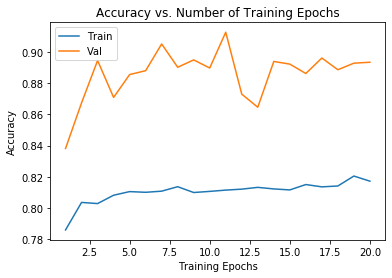

In [10]:
NUM_EPOCHS = 20
if TRAIN:
    # Train and evaluate
    model, val_hist, train_hist = train_model(
        model, 
        dataloaders_dict, 
        criterion, 
        optimizer_ft, 
        num_epochs=NUM_EPOCHS,
        lr_scheduler=scheduler_ft)
    save_model(model, path='vgg16_3.pt')
    save_history(train_hist, val_hist, 'train_hist_3.pickle', 'val_hist_3.pickle')
else:
    load_model(model, path='vgg16_3.pt')
    train_hist, val_hist = load_history('train_hist_3.pickle', 'val_hist_3.pickle')

plot_training_hist(train_hist, val_hist)    

## Fine tune top convolutional layers

In [11]:
# print(model)

# Freeze weights
for param in model.parameters():
    param.requires_grad = False
    
# Unfreeze top layers
for param in model.features[23:].parameters():
    param.requires_grad = True
    
for param in model.classifier.parameters():
    param.requires_grad = True

In [12]:
# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model.parameters()
print("Params to learn:")

params_to_update = []
for name,param in model.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=1e-3, momentum=0.9)
scheduler_ft = optim.lr_scheduler.ReduceLROnPlateau(optimizer_ft, patience=5)

# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

Params to learn:
	 features.24.weight
	 features.24.bias
	 features.26.weight
	 features.26.bias
	 features.28.weight
	 features.28.bias
	 classifier.0.weight
	 classifier.0.bias
	 classifier.3.weight
	 classifier.3.bias
	 classifier.6.weight
	 classifier.6.bias


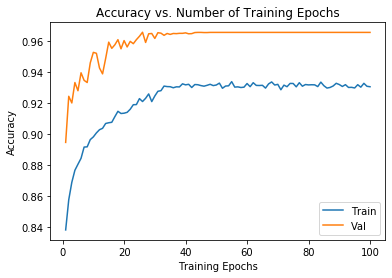

In [13]:
NUM_EPOCHS = 100
if TRAIN:
    # Train and evaluate
    model, val_hist, train_hist = train_model(model, 
                                              dataloaders_dict, 
                                              criterion, 
                                              optimizer_ft, 
                                              num_epochs=NUM_EPOCHS,
                                              lr_scheduler=scheduler_ft)
    save_model(model, path='vgg16_fine_3.pt')
    save_history(train_hist, val_hist, 'train_hist_fine_3.pickle', 'val_hist_fine_3.pickle')
    
else:
    load_model(model, path='vgg16_fine_3.pt')
    train_hist, val_hist = load_history('train_hist_fine_3.pickle', 'val_hist_fine_3.pickle')

plot_training_hist(train_hist, val_hist)

In [14]:
print("Model accuracy:", evaluate_model(model, dataloaders_dict['val'])) 


Model accuracy: 0.9658


# Train Mahalanobis Distance function

In [15]:
def penultimate_forward_vgg16(self, x):
    x = self.features(x)
    x = self.avgpool(x)
    x = x.view(x.size(0), -1)
    
    # Break up self.classifier
    penultimate = model.classifier[:5](x)
    out = model.classifier[5:](penultimate)
    return out, penultimate

# Bind a function to the model to extract penultimate features
model.penultimate_forward = penultimate_forward_vgg16.__get__(model)

In [16]:
def extract_features(model, dataloader, feature_size, num_classes):
    all_outputs = np.empty((0,num_classes))
    all_features = np.empty((0,feature_size))
    all_labels = np.empty(0)

    model.eval()
    for X, Y in tqdm(dataloader, total=len(dataloader)):
        X = X.to(device)

        outputs, features = model.penultimate_forward(X)

        features = features.view((features.size(0), features.size(1), -1))
        features = torch.mean(features, 2)

        features = features.detach().cpu().numpy()

        all_features = np.concatenate((all_features, features), axis=0)
        all_outputs = np.concatenate((all_outputs, outputs.detach().cpu().numpy()), axis=0)
        all_labels = np.concatenate((all_labels, Y.detach().cpu().numpy()), axis=0)
        
    return all_outputs, all_features, all_labels

In [17]:
# Get penultimate features, outputs, and labels from datasets set
if TRAIN:
    model.eval()
    
    for dataset in ['train_no_aug', 'val', 'ood', 'svhn']:
        softmax_outputs, mahalanobis_features, labels_out = extract_features(model, dataloaders_dict[dataset], feature_size=4096, num_classes=NUM_CLASSES)

        # Save outputs to disk
        with h5py.File(RESULTS_FILE, "a") as f:
            if dataset in f.keys():
                del f[dataset]
                
            g = f.create_group(dataset)
            g.create_dataset("softmax_outputs", data=softmax_outputs)
            g.create_dataset("mahalanobis_features", data=mahalanobis_features)
            g.create_dataset("labels", data=labels_out)

In [20]:
import sklearn.covariance

class Mahal_Dist(object):
    def __init__(self, gt_features=None, gt_labels=None):
        super().__init__()
        
        if gt_features is not None and gt_labels is not None:
            self.fit(gt_features, gt_labels)
        
    def fit(self, gt_features, gt_labels, num_classes):
        """Fit parameters used for Mahalanobis distance."""
        self.class_means = []
        centered_features = gt_features.copy()

        for i in range(num_classes):
            mask = gt_labels == i

            # Calculate the class mean
            self.class_means.append(gt_features[mask].mean(axis=0))

            # Create mean subtracted features for covariance estimation
            centered_features[mask] -= self.class_means[i]


        # Calculate the inverted covariance matrix
        group_lasso = sklearn.covariance.EmpiricalCovariance(assume_centered=False)
        group_lasso.fit(centered_features)
        self.precision = group_lasso.precision_
        self.covariance = group_lasso.covariance_

        # Convert to pytorch tensors
        self.class_means = torch.from_numpy(np.array(self.class_means)).float().to(device)
        self.precision = torch.from_numpy(self.precision).float().to(device)
        self.covariance = torch.from_numpy(self.covariance).float().to(device)
        
        
    def __call__(self, features):
        """Return the distance based confidence score to each 
            of the means."""
        # Tile the features and means to vectorize the operation
        num_means = self.class_means.shape[0]
        num_feats = features.shape[0]

        features = features.repeat(1, num_means).view(-1, features.shape[1])

        # subtract means in batches
        x = features - self.class_means.repeat(num_feats, 1)

        # matmul, take diagonal, then reshape
        dists = x.mm(self.precision).mm(x.transpose(0,1)).diag()
        dists = dists.view(num_feats, num_means).transpose(0,1)

        return dists
    
    
    def label_dist(self, features):
        """Return the label of the closest mean and the 
            mahalanobis distance to it."""
        dists = self(features)
        min_dists, labels = dists.min(dim=0)
        return labels, min_dists 
    
    
    def save(self, fname='mahal_distance.h5'):
        """Save precomputed Mahal_Dist object with all means and covariance matrix."""
        with h5py.File(fname, 'a') as f:
            # Remove old data if exists
            if "mahal_distance" in f.keys():
                del f['mahal_distance']
                
            # Store the new data
            g = f.create_group("mahal_distance")
            g.create_dataset("means", data=self.class_means.detach().cpu().numpy())
            g.create_dataset("cov", data=self.covariance.detach().cpu().numpy())
            g.create_dataset("inv_cov", data=self.precision.detach().cpu().numpy())
           
        
    @classmethod
    def load(cls, fname='mahal_distance.h5', device=torch.device("cpu")):
        """Load precomputed Mahal_Dist object with all means and covariance matrix."""
        inst = cls()
        
        with h5py.File(fname, 'r') as f:
            inst.class_means = torch.Tensor(f['mahal_distance/means'].value).to(device)
            inst.covariance = torch.Tensor(f['mahal_distance/cov'].value).to(device)
            inst.precision = torch.Tensor(f['mahal_distance/inv_cov'].value).to(device)
        
        return inst

In [21]:
if TRAIN:  
    with h5py.File(RESULTS_FILE, "r") as f:
        mahalanobis_features_train = f['train_no_aug/mahalanobis_features'].value
        labels_train = f['train_no_aug/labels'].value
    
    md = Mahal_Dist()
    md.fit(mahalanobis_features_train, labels_train, num_classes=NUM_CLASSES)
    md.save(RESULTS_FILE)
else:
    md = Mahal_Dist.load(RESULTS_FILE, device)

# Extract FG, BG, OOD Softmax predictions and Mahal features

In [22]:
from torch import Tensor

if TRAIN:
    for dataset in ['val', 'ood', 'svhn']:
        print(dataset)
        with h5py.File(RESULTS_FILE, 'r') as f:
            g = f[dataset]
            labels = g['labels'][()]
            features = g['mahalanobis_features'][()]
            outputs = g['softmax_outputs'][()]    
        
        # Get predicted labels, distance to nearest mean
        cur = 0
        mahalanobis_labels = np.empty(0,)
        mahalanobis_dists = np.empty(0,)
        while cur < len(features):
            l, d = md.label_dist(Tensor(features[cur:cur+BATCH_SIZE]).to(device))
            mahalanobis_labels = np.concatenate((mahalanobis_labels, l.detach().cpu().numpy()), axis=0)
            mahalanobis_dists = np.concatenate((mahalanobis_dists, d.detach().cpu().numpy()), axis=0)
            cur += BATCH_SIZE
        
        with h5py.File(RESULTS_FILE, 'a') as f:
            g = f[dataset]
            if 'mahalanobis_labels' in g.keys():
                del g['mahalanobis_labels']
            g.create_dataset('mahalanobis_labels', data=mahalanobis_labels)
            if 'mahalanobis_dists' in g.keys():
                del g['mahalanobis_dists']
            g.create_dataset('mahalanobis_dists', data=mahalanobis_dists)    

In [23]:
with h5py.File(RESULTS_FILE, 'r') as f:
    g = f['val']
    labels_val = g['labels'][()]
    mahalanobis_labels_val = g['mahalanobis_labels'][()]
    mahalanobis_dist_val = g['mahalanobis_dists'][()]

correct = np.sum((mahalanobis_labels_val == labels_val).astype(np.int))
print("%d%% of val data classified correctly with mahalanobis distance" % (correct / len(labels_val) * 100))

96% of val data classified correctly with mahalanobis distance


# Regular Mahalanobis to separate CIFAR10 and CIFAR100

(10000,)
(10000,)


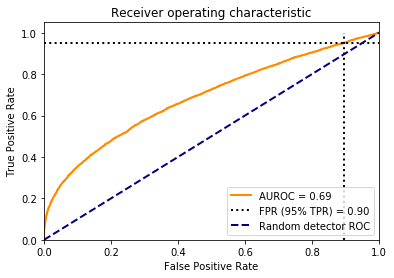

In [24]:
with h5py.File(RESULTS_FILE, "r") as f:
    mahalanobis_dist_val = f['val/mahalanobis_dists'].value
    print(mahalanobis_dist_val.shape)
    labels_val = f['val/labels'].value

    mahalanobis_dist_ood = f['ood/mahalanobis_dists'].value
    print(mahalanobis_dist_ood.shape)
    labels_ood = f['ood/labels'].value

scores = np.concatenate((mahalanobis_dist_val, mahalanobis_dist_ood), axis=0)
labels = np.concatenate((np.zeros(len(mahalanobis_dist_val)), np.ones(len(mahalanobis_dist_ood))), axis=0)

plot_roc(scores, labels)

# Problem statement

In [31]:
from umap import UMAP

with h5py.File(RESULTS_FILE, 'r') as f:
    features_train = f['train_no_aug/mahalanobis_features'].value
    labels_train = f['train_no_aug/labels'].value
    
    features_val = f['val/mahalanobis_features'].value
    labels_val = f['val/labels'].value + 2
    
    features_ood = f['ood/mahalanobis_features'].value
    labels_ood = np.ones(len(features_ood)) * 4
    
features = np.concatenate((features_train, features_val, features_ood), axis=0)
labels = np.concatenate((labels_train, labels_val, labels_ood), axis=0).astype(np.int)

In [26]:
embedding = UMAP(n_neighbors=30).fit_transform(features)

/home/tadenoud/anaconda3/envs/nn/lib/python3.6/site-packages/umap/rp_tree.py:450: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "make_euclidean_tree" failed type inference due to: Cannot unify RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none) and RandomProjectionTreeNode(none, bool, array(float32, 1d, C), float64, RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none), RandomProjectionTreeNode(array(int64, 1d, C), bool, none, none, none, none)) for '$14.16', defined at /home/tadenoud/anaconda3/envs/nn/lib/python3.6/site-packages/umap/rp_tree.py (457)

File "../../../anaconda3/envs/nn/lib/python3.6/site-packages/umap/rp_tree.py", line 457:
def make_euclidean_tree(data, indices, rng_state, leaf_size=30):
    <source elided>

        left_node = make_euclidean_tree(data, left_indices, rng_state, leaf_size)
        ^

[1] During: resolving callee type: recursive(type(CPUDispatcher(<function

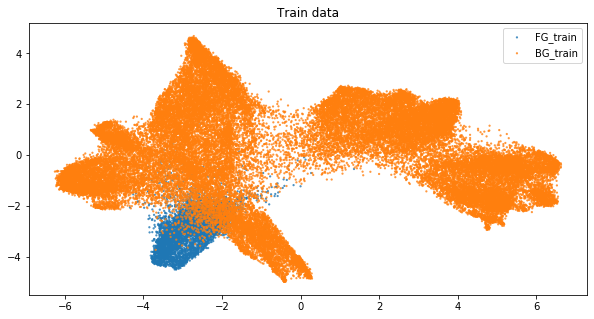

In [48]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

fig, ax = plt.subplots(figsize=(10, 5))
plt.title("Train data")
text_labels = ['FG_train', 'BG_train']

for label in range(len(text_labels)):
    x = embedding[:,0][labels == label]
    y = embedding[:,1][labels == label]
    ax.scatter(x, y, c=colors[label], s=5, label=text_labels[label], alpha=0.8, edgecolors='none')

ax.legend()
plt.show()

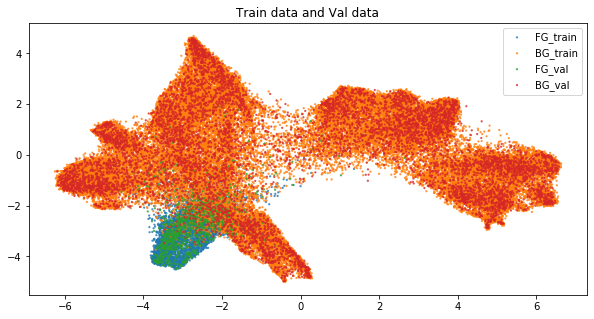

In [36]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

fig, ax = plt.subplots(figsize=(10, 5))
plt.title("Train data and Val data")
text_labels = ['FG_train', 'BG_train', 'FG_val', 'BG_val']

for label in range(len(text_labels)):
    x = embedding[:,0][labels == label]
    y = embedding[:,1][labels == label]
    ax.scatter(x, y, c=colors[label], s=5, label=text_labels[label], alpha=0.8, edgecolors='none')

ax.legend()
plt.show()

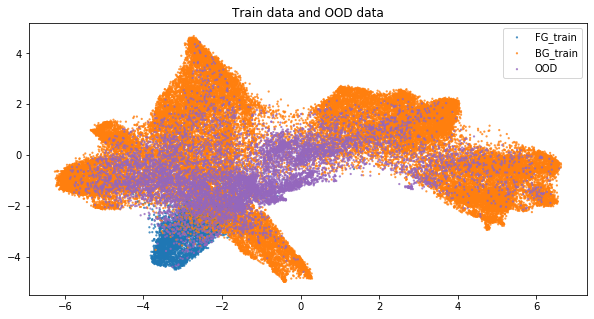

In [47]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.title("Train data and OOD data")
text_labels = ['FG_train', 'BG_train', 'OOD']

for label in range(len(text_labels)):
    legend_label = text_labels[label]
    if legend_label == 'OOD':
        label = 4
    
    x = embedding[:,0][labels == label]
    y = embedding[:,1][labels == label]
    ax.scatter(x, y, c=colors[label], s=5, label=legend_label, alpha=0.8, edgecolors='none')

ax.legend()
plt.show()

Possible problem solutions

- Cluster inlier classes used for Mahalanobis distance using GMM
    - Problem: How many components? What form of covariance?
    
- Increase interclass distance in feature space using Polarity Loss

- Buu provided paper on Neural Random Forest for OOD detection (https://openreview.net/forum?id=HygTE309t7)

## GMM approach

In [39]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=10, covariance_type='tied')
gmm.fit(features_train)

GaussianMixture(covariance_type='tied', init_params='kmeans', max_iter=100,
                means_init=None, n_components=10, n_init=1,
                precisions_init=None, random_state=None, reg_covar=1e-06,
                tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
                weights_init=None)

In [40]:
gmm_labels = gmm.predict(features)

gmm_labels_train = gmm_labels[:50000]
gmm_labels_val = gmm_labels[50000:60000]
gmm_labels_ood = gmm_labels[60000:]

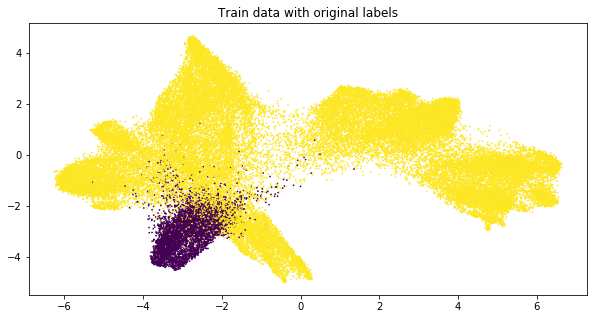

In [44]:
plt.figure(figsize=(10, 5))
plt.title("Train data with original labels")
plt.scatter(embedding[:50000,0], embedding[:50000,1], c=labels_train, s=0.5)
plt.show()

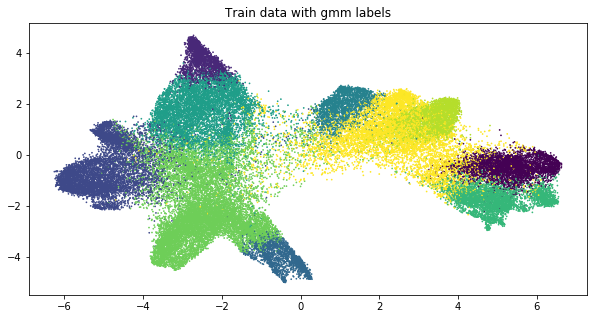

In [45]:
plt.figure(figsize=(10, 5))
plt.title("Train data with gmm labels")
plt.scatter(embedding[:50000,0], embedding[:50000,1], c=gmm_labels_train, s=0.5)
plt.show()

## Polarity Loss approach

## Neural Random Forest

## Outlier Exposure

## More poorly trained VGG

## Densenet based model